# 1. Problem & Data Description

**Challenge overview.** We tackle the Kaggle "Histopathologic Cancer Detection" task: given 96×96 RGB patches cropped from lymph node tissue, predict whether the center 32×32 region contains metastatic tissue. 

**Clinical motivation.** Automated detection mitigates pathologist workload and reduces diagnostic latency. False negatives are costly (missed metastasis), so evaluation focuses on ROC AUC in addition to accuracy.

**Dataset summary.**
- Training set: 220,025 labeled tiles. Each tile is 96×96 pixels with 3 channels.
- Test set: 57,000 tiles (unlabeled on Kaggle). For local validation we reserve 20 % of the training data.

In [1]:
from __future__ import annotations

import itertools
import math
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image

# TensorFlow is imported lazily later to keep startup time low.

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams.update({"figure.figsize": (8, 5), "axes.spines.top": False, "axes.spines.right": False})

PATH = Path("../input/histopathologic-cancer-detection")
TRAIN_DIR = PATH / "train"
TEST_DIR = PATH / "test"
LABELS_PATH = PATH / "train_labels.csv"

# 2. Exploratory Data Analysis

In [2]:
def load_metadata(labels_csv: Path = LABELS_PATH) -> pd.DataFrame:
    """Read train_labels.csv and join absolute paths if available."""

    if not labels_csv.exists():
        raise FileNotFoundError(f"Could not find {labels_csv}.")

    df = pd.read_csv(labels_csv)
    df["path"] = df["id"].map(lambda stem: (TRAIN_DIR / f"{stem}.tif").as_posix())
    return df


labels_df = load_metadata()
labels_df.head()


,id,label,path
0,f38a6374c348f90b587e046aac6079959adf3835,0,../input/histopathologic-cancer-detection/trai...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,../input/histopathologic-cancer-detection/trai...
2,755db6279dae599ebb4d39a9123cce439965282d,0,../input/histopathologic-cancer-detection/trai...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,../input/histopathologic-cancer-detection/trai...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,../input/histopathologic-cancer-detection/trai...


### 2.1 Dataset cleanup & label balance

We start with descriptive stats, missing-value checks, and class balance to understand sampling bias and volume. Kaggle reported two problematic tiles in 2018 competitions; we explicitly drop them to avoid crashy reads.

In [3]:
PROBLEMATIC_IMAGES = {
    "dd6dfed324f9fcb6f93f46f32fc800f2ec196be2",  # corrupted file
    "9369c7278ec8bcc6c880d99194de09fc2bd4efbe",  # all zeros / black tile
}


def clean_metadata(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    before = len(df)
    df = df[~df["id"].isin(PROBLEMATIC_IMAGES)].copy()
    dropped = before - len(df)
    if dropped:
        print(f"Removed {dropped} known problematic tiles.")
    return df


labels_df = clean_metadata(labels_df)


summary = {
    "total_tiles": int(len(labels_df)),
    "positive_tiles": int(labels_df["label"].sum()),
    "negative_tiles": int((labels_df["label"] == 0).sum()),
    "class_ratio_pos": labels_df["label"].mean(),
}
summary_series = pd.Series(summary, name="dataset_summary", dtype=object)
display(summary_series)

Removed 2 known problematic tiles.


total_tiles         220023
positive_tiles       89116
negative_tiles      130907
class_ratio_pos    0.40503
Name: dataset_summary, dtype: object

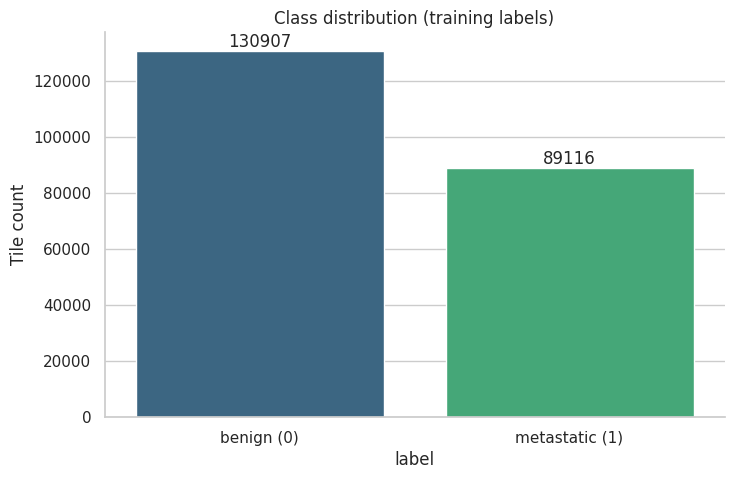

In [4]:
fig, ax = plt.subplots()
sns.countplot(data=labels_df, x="label", palette="viridis", ax=ax)
ax.set_xticklabels(["benign (0)", "metastatic (1)"])
ax.set_ylabel("Tile count")
ax.set_title("Class distribution (training labels)")
for container in ax.containers:
    ax.bar_label(container, fmt="%d")
plt.show()


The training dataset shows a moderate class imbalance between the two categories:

- Benign (0): 130,907 tiles
- Metastatic (1): 89,116 tiles

This corresponds to roughly a 60/40 split in favor of the benign (negative) class.

While this is not a severe imbalance, it’s still large enough to potentially bias the model toward predicting the majority class. To mitigate this, techniques such as class weighting, balanced sampling, or data augmentation for the minority class can be applied during training.

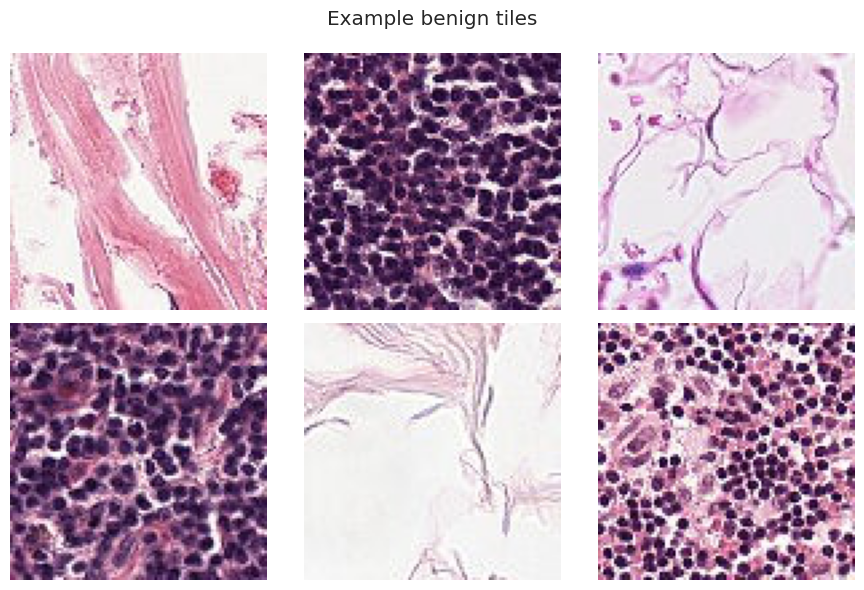

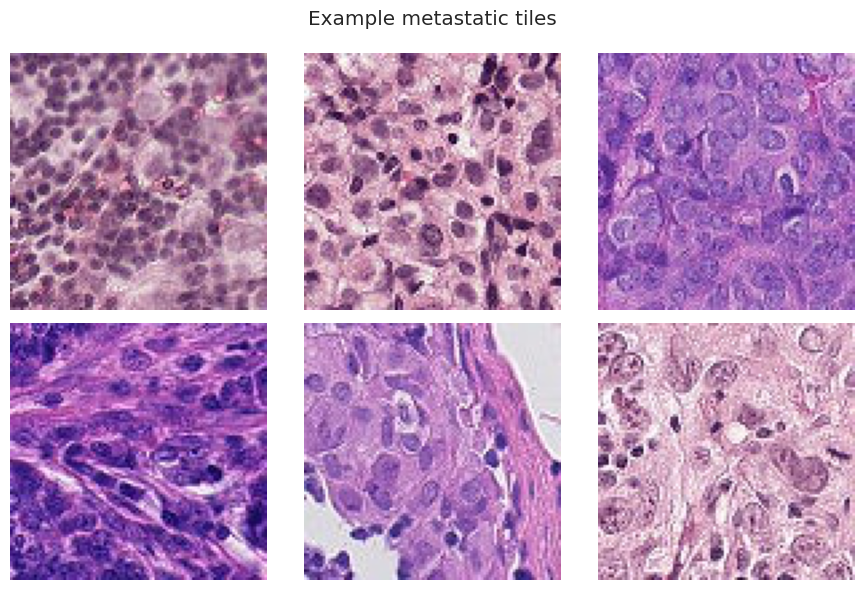

In [5]:
def load_tile(path: Path) -> Optional[np.ndarray]:
    try:
        with Image.open(path) as img:
            return np.array(img)
    except (FileNotFoundError, IsADirectoryError):
        return None


def sample_tiles(df: pd.DataFrame, label: int, n: int = 6) -> List[np.ndarray]:
    subset = df[df["label"] == label]
    if subset.empty:
        return []
    sample_ids = subset.sample(min(n, len(subset)), random_state=42)
    return [load_tile(Path(path)) for path in sample_ids["path"]]


def plot_tile_grid(tiles: List[np.ndarray], title: str, cols: int = 3) -> None:
    if not tiles:
        print("No tiles to display (check dataset availability).")
        return
    rows = math.ceil(len(tiles) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = np.atleast_2d(axes)
    for ax, tile in itertools.zip_longest(axes.flatten(), tiles):
        ax.axis("off")
        if tile is not None:
            ax.imshow(tile)
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


if not labels_df.empty:
    plot_tile_grid(sample_tiles(labels_df, label=0), "Example benign tiles")
    plot_tile_grid(sample_tiles(labels_df, label=1), "Example metastatic tiles")


Visual inspection reveals observable differences between the two classes:

- **Benign tiles** tend to show more regular, organized patterns with consistent coloring
- **Metastatic tiles** display more irregular patterns in both color intensity and cellular shapes, with denser clustering of dark-stained regions

These visual irregularities suggest that texture and color features should be useful for classification by a CNN.

In [6]:
def compute_channel_stats(df: pd.DataFrame, sample_size: int = 2000) -> Optional[pd.DataFrame]:
    if df.empty:
        return None
    sample = df.sample(min(sample_size, len(df)), random_state=123)
    stacks = [load_tile(Path(path)) for path in sample["path"]]
    stacks = [tile for tile in stacks if tile is not None]
    if not stacks:
        return None
    data = np.stack(stacks)
    flat = data.reshape(-1, 3)
    means = flat.mean(axis=0)
    stds = flat.std(axis=0)
    brightness = data.mean(axis=(1, 2, 3))
    return pd.DataFrame(
        {
            "channel": ["red", "green", "blue", "overall"],
            "mean": [means[0], means[1], means[2], brightness.mean()],
            "std": [stds[0], stds[1], stds[2], brightness.std()],
        }
    )


channel_stats = compute_channel_stats(labels_df)
channel_stats


,channel,mean,std
0,red,177.186917,61.424299
1,green,136.677998,71.689226
2,blue,175.650872,55.800537
3,overall,163.171929,38.302309


The dataset shows mean pixel intensities of 177.2 (red), 136.7 (green), and 175.7 (blue) with standard deviations of 61.4, 71.7, and 55.8 respectively.
Key Finding: The green channel exhibits the highest variance (std: 71.7), suggesting it captures the most discriminative information for distinguishing between cancerous and non-cancerous tissue regions. This aligns with H&E staining characteristics where cellular morphology differences are prominent.


**Impact:** These statistics confirm the need for image normalization during preprocessing and indicate sufficient dataset variability for robust model training.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


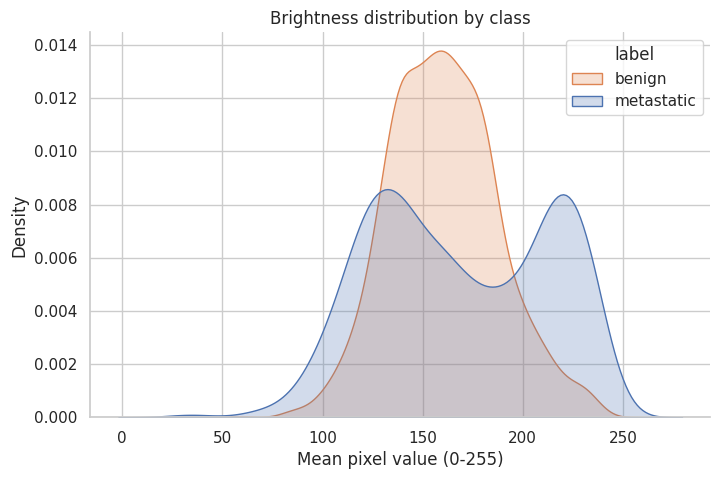

In [7]:
def brightness_distribution(df: pd.DataFrame, sample_size: int = 4000) -> None:
    if df.empty:
        print("Dataset not loaded; skipping brightness plot.")
        return
    sample = df.sample(min(sample_size, len(df)), random_state=7)
    records: List[Dict[str, float]] = []
    for _, row in sample.iterrows():
        tile = load_tile(Path(row["path"]))
        if tile is None:
            continue
        records.append({"label": row["label"], "brightness": tile.mean()})
    if not records:
        print("No tiles decoded; ensure the TIFF images are present.")
        return
    df_brightness = pd.DataFrame(records)
    fig, ax = plt.subplots()
    sns.kdeplot(data=df_brightness, x="brightness", hue="label", fill=True, common_norm=False, ax=ax)
    ax.set_title("Brightness distribution by class")
    ax.set_xlabel("Mean pixel value (0-255)")
    ax.legend(title="label", labels=["benign", "metastatic"])
    plt.show()


brightness_distribution(labels_df)


Benign tissue (orange) shows uniform brightness centered around 150, while metastatic tissue (blue) exhibits a bimodal distribution with peaks at ~120 and ~220, reflecting the heterogeneous nature of cancerous tissue.

## 3. Model Architecture

We implement two CNN architectures using TensorFlow/Keras, both designed for binary classification on 96×96 RGB histopathology images.

### 1. Baseline CNN

A straightforward architecture inspired by this [Kaggle kernel](https://www.kaggle.com/code/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93), consisting of three convolutional blocks followed by a classification head:

**Convolutional blocks (3×):**
- Conv2D → BatchNormalization → ReLU activation
- MaxPooling2D (2×2) for spatial downsampling
- Dropout for regularization
- Progressive filter expansion: 32 → 64 → 128 filters

**Classification head:**
- Flatten layer to convert spatial features to 1D
- Dense layer with dropout
- Sigmoid output for binary classification

**Training configuration:**
- Optimizer: Adam with default learning rate (1e-3)
- Loss: Binary crossentropy
- No data augmentation

### 2. Improved CNN

An enhanced architecture incorporating modern techniques and attention mechanisms:

**Architectural improvements:**
- **Squeeze-and-excitation blocks**: Channel-wise attention after each convolutional block to reweight feature maps based on global context
- **Increased capacity**: Higher filter counts per block (48 → 96 → 192) to capture richer representations
- **Deeper convolutions**: Two Conv2D layers per block instead of one

**Regularization strategy:**
- Data augmentation pipeline (rotation, flips, shifts, zoom) applied during training
- Dropout at multiple stages (convolutional and dense layers)

**Optimization setup:**
- AdamW optimizer with weight decay for better generalization
- Cosine annealing learning rate schedule that gradually reduces LR over training epochs
- Configurable initial learning rate

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

AUTOTUNE = tf.data.AUTOTUNE
INPUT_SIZE = (96, 96)
BATCH_SIZE = 64
VAL_SPLIT = 0.2
SEED = 2024


def decode_tiff(path: str) -> np.ndarray:
    """
    Decode a TIFF image file using PIL.
    Returns uint8 numpy array [height, width, 3].
    """
    with Image.open(path) as img:
        # Convert to RGB if needed (handles grayscale, RGBA, etc.)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Resize if not already 96x96
        if img.size != INPUT_SIZE:
            img = img.resize(INPUT_SIZE, Image.BILINEAR)
        
        # Convert to numpy array (uint8)
        image = np.array(img, dtype=np.uint8)
    
    return image


def load_and_preprocess(path: tf.Tensor, label: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    """
    Load a TIFF file and return as uint8 tensor for augmentation.
    """
    # Decode path from tensor to string
    def _load_image(path_bytes):
        path_str = path_bytes.numpy().decode('utf-8')
        return decode_tiff(path_str)
    
    # Use py_function to wrap the PIL-based loading
    image = tf.py_function(_load_image, [path], tf.uint8)
    image.set_shape([INPUT_SIZE[0], INPUT_SIZE[1], 3])
    
    return image, label


def preprocess_image(image: tf.Tensor) -> tf.Tensor:
    """
    Normalize to [0, 1] range. 
    
    Preserves global brightness differences which are discriminative 
    for cancer vs. benign classification (per EDA findings).
    """
    # Convert from uint8 [0, 255] to float32 [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image


def build_dataset_from_directory(
    directory: Path,
    subset: Optional[str],
    augment: bool = False,
) -> tf.data.Dataset:
    """
    Build a tf.data.Dataset pipeline with loading, augmentation, and preprocessing.
    
    Args:
        directory: Path to image directory (used for reference, actual paths from metadata)
        subset: "training" or "validation" to split data, None for all data
        augment: Whether to apply data augmentation
    
    Returns:
        A batched, prefetched tf.data.Dataset ready for training/evaluation
    """
    # Load metadata and split if needed
    df = load_metadata()
    df = clean_metadata(df)
    
    # Split into train/val based on subset
    if subset is not None:
        train_df, val_df = train_test_split(
            df, test_size=VAL_SPLIT, random_state=SEED, stratify=df["label"]
        )
        if subset == "training":
            df = train_df
        elif subset == "validation":
            df = val_df
    
    # Create dataset from file paths and labels
    file_paths = df["path"].values
    labels = df["label"].values.astype(np.float32)
    
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    
    # Load images using PIL (via py_function for reliability)
    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    
    # Apply augmentation if requested (operates on uint8 images)
    if augment:
        augmentation = keras.Sequential(
            [
                layers.RandomFlip("horizontal_and_vertical"),
                layers.RandomRotation(0.1),
                layers.RandomZoom(0.1),
            ],
            name="augmentation",
        )
        ds = ds.map(lambda x, y: (augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

    # Normalize to [0, 1] range (preserves brightness differences)
    ds = ds.map(lambda x, y: (preprocess_image(x), y), num_parallel_calls=AUTOTUNE)
    
    # Batch and prefetch for performance
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    
    return ds


train_ds = build_dataset_from_directory(TRAIN_DIR, subset="training", augment=True)
val_ds = build_dataset_from_directory(TRAIN_DIR, subset="validation", augment=False)

2025-11-14 10:50:36.761798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763117436.940447      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763117436.982717      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Removed 2 known problematic tiles.


I0000 00:00:1763117452.665488      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763117452.666209      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Removed 2 known problematic tiles.


In [9]:
def build_baseline_model(
    input_shape: Tuple[int, int, int] = (INPUT_SIZE[0], INPUT_SIZE[1], 3),
    dropout_conv: float = 0.3,
    dropout_dense: float = 0.5,
    learning_rate: float = 1e-3,
) -> keras.Model:
    """
    Baseline CNN architecture following Kaggle starter pattern.
    3 convolutional blocks with batch normalization, max pooling, and dropout.
    """
    kernel_size = (3, 3)
    pool_size = (2, 2)
    first_filters = 32
    second_filters = 64
    third_filters = 128
    
    model = keras.Sequential(name="baseline_cnn")
    
    # Conv block 1
    model.add(layers.Conv2D(first_filters, kernel_size, input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.Conv2D(first_filters, kernel_size, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.MaxPooling2D(pool_size=pool_size))
    model.add(layers.Dropout(dropout_conv))
    
    # Conv block 2
    model.add(layers.Conv2D(second_filters, kernel_size, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.Conv2D(second_filters, kernel_size, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.MaxPooling2D(pool_size=pool_size))
    model.add(layers.Dropout(dropout_conv))
    
    # Conv block 3
    model.add(layers.Conv2D(third_filters, kernel_size, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.Conv2D(third_filters, kernel_size, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.MaxPooling2D(pool_size=pool_size))
    model.add(layers.Dropout(dropout_conv))
    
    # Fully connected layer
    model.add(layers.Flatten())
    model.add(layers.Dense(256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.Dropout(dropout_dense))
    
    # Output layer
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=[keras.metrics.BinaryAccuracy(name="accuracy"), keras.metrics.AUC(name="roc_auc")],
    )
    return model


baseline_model = build_baseline_model()
baseline_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "baseline_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 94, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 94, 94, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 92, 92, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 92, 92, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 92, 92, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 44, 44, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 44, 44, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 44, 44, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 42, 42, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 42, 42, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 19, 19, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 17, 17, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 17, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 17, 17, 128)    │             

 Total params: 2,386,817 (9.10 MB)

 Trainable params: 2,385,409 (9.10 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [10]:
def build_improved_model(
    input_shape: Tuple[int, int, int] = (INPUT_SIZE[0], INPUT_SIZE[1], 3),
    base_filters: int = 48,
    dropout_conv: float = 0.35,
    dropout_dense: float = 0.5,
    learning_rate: float = 3e-4,
) -> keras.Model:
    """
    Improved CNN with squeeze-and-excitation blocks and global average pooling.
    
    Key improvements over baseline:
    - Wider filters (48 → 96 → 192 instead of 32 → 64 → 128)
    - Squeeze-and-excitation attention mechanism
    - GlobalAveragePooling2D instead of Flatten (reduces parameters)
    - AdamW optimizer with weight decay
    - Consistent use_bias=False with BatchNormalization
    """
    kernel_size = (3, 3)
    pool_size = (2, 2)
    
    inputs = layers.Input(shape=input_shape)
    x = inputs
    
    # Conv block 1 (48 filters) with squeeze-excitation
    x = layers.Conv2D(base_filters, kernel_size, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(base_filters, kernel_size, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    # Squeeze-and-excitation block
    squeeze = layers.GlobalAveragePooling2D()(x)
    squeeze = layers.Dense(base_filters // 4, activation="relu")(squeeze)
    squeeze = layers.Dense(base_filters, activation="sigmoid")(squeeze)
    squeeze = layers.Reshape((1, 1, base_filters))(squeeze)
    x = layers.Multiply()([x, squeeze])
    
    x = layers.MaxPooling2D(pool_size=pool_size)(x)
    x = layers.Dropout(dropout_conv)(x)
    
    # Conv block 2 (96 filters) with squeeze-excitation
    x = layers.Conv2D(base_filters * 2, kernel_size, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(base_filters * 2, kernel_size, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    # Squeeze-and-excitation block
    squeeze = layers.GlobalAveragePooling2D()(x)
    squeeze = layers.Dense(base_filters // 2, activation="relu")(squeeze)
    squeeze = layers.Dense(base_filters * 2, activation="sigmoid")(squeeze)
    squeeze = layers.Reshape((1, 1, base_filters * 2))(squeeze)
    x = layers.Multiply()([x, squeeze])
    
    x = layers.MaxPooling2D(pool_size=pool_size)(x)
    x = layers.Dropout(dropout_conv)(x)
    
    # Conv block 3 (192 filters) - no SE block to reduce computation
    x = layers.Conv2D(base_filters * 4, kernel_size, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(base_filters * 4, kernel_size, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=pool_size)(x)
    x = layers.Dropout(dropout_conv)(x)
    
    # Additional conv layer before global pooling
    x = layers.Conv2D(base_filters * 8, kernel_size, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    # Global average pooling instead of Flatten (reduces parameters)
    x = layers.GlobalAveragePooling2D()(x)
    
    # Dense layers
    x = layers.Dense(256, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(dropout_dense)(x)
    
    # Output layer
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="improved_cnn")
    
    # AdamW with weight decay for better regularization
    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-4)
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=[keras.metrics.BinaryAccuracy(name="accuracy"), keras.metrics.AUC(name="roc_auc")],
    )
    return model


improved_model = build_improved_model()
improved_model.summary()


Model: "improved_cnn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 96, 96,    │      1,296 │ input_layer_2[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 96,    │        192 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 96, 96,    │          0 │ batch_normalizat… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 96, 96,    │     20,736 │ activation_7[0][… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 96,    │        192 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 96, 96,    │          0 │ batch_normalizat… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 48)        │          0 │ activation_8[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 12)        │        588 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 48)        │        624 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 48)  │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 96, 96,    │          0 │ activation_8[0][… │
│                     │ 48)               │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 48, 48,    │          0 │ multiply[0][0]    │
│ (MaxPooling2D)      │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 48, 48,    │          0 │ max_pooling2d_3[… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 48, 48,    │     41,472 │ dropout_4[0][0]   │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        384 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 48, 48,    │     82,944 │ activation_9[0][

 Total params: 1,417,413 (5.41 MB)

 Trainable params: 1,414,789 (5.40 MB)

 Non-trainable params: 2,624 (10.25 KB)

In [11]:
def train_experiment(
    model_builder,
    *,
    model_name: str,
    learning_rate: float,
    dropout_conv: float,
    dropout_dense: float,
    epochs: int = 12,
    callbacks: Optional[List[keras.callbacks.Callback]] = None,
    verbose: int = 1,
) -> Dict[str, float | str | keras.callbacks.History]:
    model = model_builder(learning_rate=learning_rate, dropout_conv=dropout_conv, dropout_dense=dropout_dense)
    callbacks = callbacks or []

    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks=callbacks,
        verbose=verbose
    )
    eval_metrics = model.evaluate(val_ds, verbose=0, return_dict=True)

    result = {
        "model_name": model_name,
        "learning_rate": learning_rate,
        "dropout_conv": dropout_conv,
        "dropout_dense": dropout_dense,
        "epochs_trained": len(history.history["loss"]),
        "val_loss": float(eval_metrics["loss"]),
        "val_accuracy": float(eval_metrics["accuracy"]),
        "val_roc_auc": float(eval_metrics["roc_auc"]),
        "history": history,
        "model": model,  # Return the trained model
    }
    return result


In [12]:
def run_experiments(
    learning_rate: float = 1e-3,
    epochs: int = 12,
    verbose: int = 1,
    checkpoint_callbacks: Optional[List[keras.callbacks.Callback]] = None
) -> List[Dict[str, float | str | keras.callbacks.History]]:

    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_roc_auc",
        patience=3,
        mode="max",
        restore_best_weights=True,
        verbose=1,
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_roc_auc",
        patience=2,
        mode="max",
        factor=0.1,
        min_lr=1e-6,
        cooldown=1,
        verbose=1,
    )

    # Base callbacks that always run
    base_callbacks = [early_stopping, reduce_lr]
    
    # Add checkpoint callbacks if provided
    all_callbacks = base_callbacks + (checkpoint_callbacks or [])

    if checkpoint_callbacks:
        print(f"Checkpoints enabled: {len(checkpoint_callbacks)} checkpoint callback(s)")
    else:
        print("Checkpoints disabled")

    experiments: List[Dict[str, float | str | keras.callbacks.History]] = []

    # Define models to train
    models_to_train = [
        {
            "name": "baseline_" + str(learning_rate),
            "builder": build_baseline_model,
            "dropout_conv": 0.3,
            "dropout_dense": 0.5,
        },
        {
            "name": "improved_" + str(learning_rate),
            "builder": build_improved_model,
            "dropout_conv": 0.35,
            "dropout_dense": 0.45,
        },
    ]


    for model_config in models_to_train:
        model_name = model_config["name"]
        print(f"\n=== Training {model_name} model (lr={learning_rate}) ===")

        try:
            result = train_experiment(
                model_config["builder"],
                model_name=model_name,
                learning_rate=learning_rate,
                dropout_conv=model_config["dropout_conv"],
                dropout_dense=model_config["dropout_dense"],
                epochs=epochs,
                callbacks=[early_stopping, reduce_lr] + all_callbacks,
                verbose=verbose
            )
            experiments.append(result)
        except Exception as exc:
            print(f"{model_name} training failed: {exc}")

    return experiments


experiment_results = run_experiments(learning_rate=0.0001, epochs=12, verbose=2)
experiment_results += run_experiments(learning_rate=0.0005, epochs=12, verbose=2)
experiment_results += run_experiments(learning_rate=0.001, epochs=12, verbose=2)

Checkpoints disabled

=== Training baseline_0.0001 model (lr=0.0001) ===
Epoch 1/12


I0000 00:00:1763117461.430591      66 service.cc:148] XLA service 0x782c54011eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763117461.431363      66 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763117461.431387      66 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763117462.410914      66 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1763117471.728369      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2751/2751 - 828s - 301ms/step - accuracy: 0.8141 - loss: 0.4285 - roc_auc: 0.8817 - val_accuracy: 0.7428 - val_loss: 0.6640 - val_roc_auc: 0.9115 - learning_rate: 1.0000e-04
Epoch 2/12

Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
2751/2751 - 522s - 190ms/step - accuracy: 0.8441 - loss: 0.3646 - roc_auc: 0.9143 - val_accuracy: 0.7074 - val_loss: 0.8802 - val_roc_auc: 0.8588 - learning_rate: 1.0000e-05
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.

=== Training improved_0.0001 model (lr=0.0001) ===
Epoch 1/12
2751/2751 - 685s - 249ms/step - accuracy: 0.8401 - loss: 0.3747 - roc_auc: 0.9102 - val_accuracy: 0.7991 - val_loss: 0.5889 - val_roc_auc: 0.9093 - learning_rate: 1.0000e-04
Epoch 2/12
2751/2751 - 645s - 234ms/step - accuracy: 0.8806 - loss: 0.2899 - roc_auc: 0.9460 - val_accuracy: 0.8296 - val_loss: 0.4958 - val_roc_auc: 0.9272 - le

# 3. Results Analysis

We compare loss, accuracy, and ROC AUC across different epochs for all tested models, with results presented in comparative tables and plots.

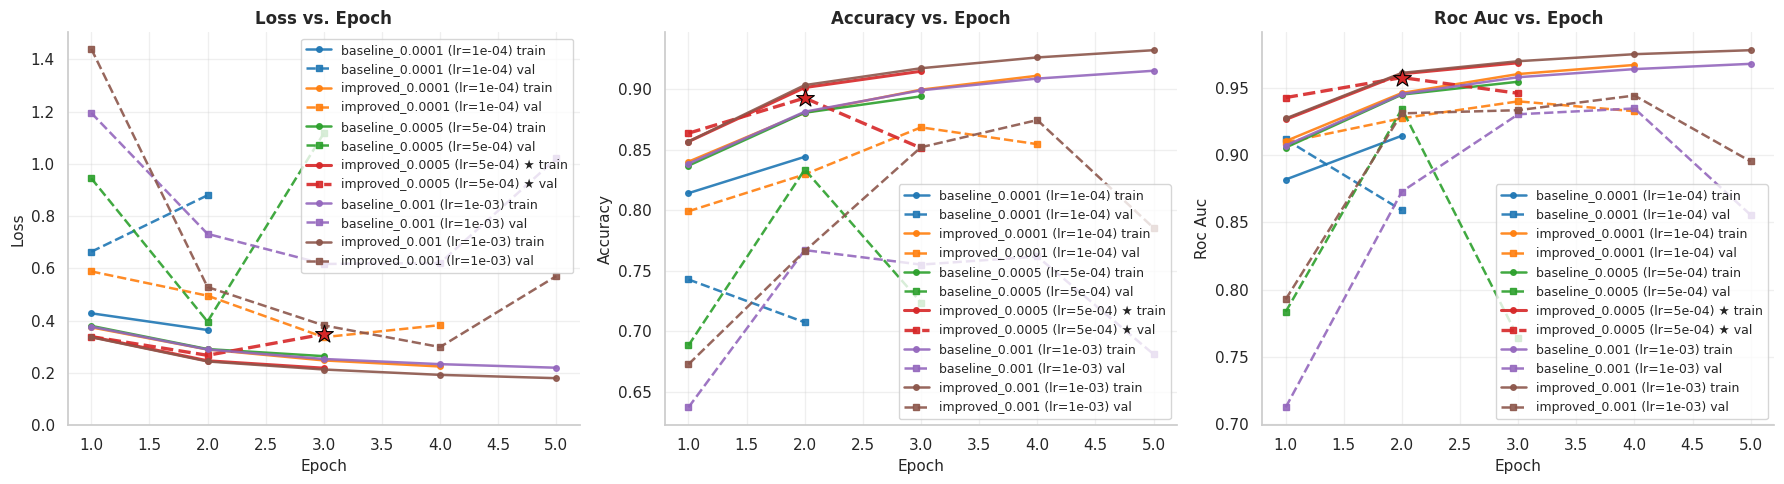

In [13]:
def plot_training_curves(
    experiments: List[Dict[str, float | str | keras.callbacks.History]],
    metrics: List[str] = ["loss", "accuracy", "roc_auc"],
) -> None:
    """
    Plot training and validation curves for multiple models across epochs.
    
    Args:
        experiments: List of experiment result dictionaries containing history
        metrics: List of metric names to plot (e.g., ["loss", "accuracy", "roc_auc"])
    """
    if not experiments:
        print("No experiment results available for plotting.")
        return

    # Identify best model by highest final validation ROC AUC
    try:
        best_exp = max(experiments, key=lambda e: float(e.get("val_roc_auc", float("-inf"))))
    except ValueError:
        best_exp = None
    
    num_metrics = len(metrics)
    fig, axes = plt.subplots(1, num_metrics, figsize=(6 * num_metrics, 5))
    
    # Handle single metric case
    if num_metrics == 1:
        axes = [axes]
    
    # Color palette for different models
    colors = plt.cm.tab10.colors
    
    for metric_idx, metric in enumerate(metrics):
        ax = axes[metric_idx]
        
        for exp_idx, exp in enumerate(experiments):
            history = exp["history"]
            model_name = exp["model_name"]
            lr = exp["learning_rate"]
            is_best = best_exp is not None and exp is best_exp
            
            # Create label with hyperparameters
            label_prefix = f"{model_name} (lr={lr:.0e})"
            if is_best:
                label_prefix += " ★"
            
            # Get training and validation metric values
            train_values = list(history.history.get(metric, []))
            val_values = list(history.history.get(f"val_{metric}", []))
            
            if not train_values and not val_values:
                continue
            
            # Epoch index from History when available; fallback to max length
            if getattr(history, "epoch", None):
                epochs_range = np.array(history.epoch) + 1
            else:
                max_len = max(len(train_values), len(val_values))
                epochs_range = np.arange(1, max_len + 1)
            
            color = colors[exp_idx % len(colors)]
            lw_train = 2.2 if is_best else 1.8
            lw_val = 2.4 if is_best else 1.8
            
            # Plot training metric (solid line)
            if train_values:
                ax.plot(
                    epochs_range[: len(train_values)],
                    train_values,
                    label=f"{label_prefix} train",
                    color=color,
                    linestyle="-",
                    marker="o",
                    markersize=4,
                    alpha=0.9,
                    linewidth=lw_train,
                )
            
            # Plot validation metric (dashed line)
            if val_values:
                ax.plot(
                    epochs_range[: len(val_values)],
                    val_values,
                    label=f"{label_prefix} val",
                    color=color,
                    linestyle="--",
                    marker="s",
                    markersize=4,
                    alpha=0.9,
                    linewidth=lw_val,
                )
                
                # Highlight best model's best validation epoch with a star marker
                if is_best:
                    best_idx = int(np.argmax(np.array(val_values)))
                    ax.scatter(
                        epochs_range[best_idx],
                        val_values[best_idx],
                        marker="*",
                        s=180,
                        color=color,
                        edgecolors="black",
                        linewidths=0.8,
                        zorder=5,
                    )
        
        # Configure subplot
        ax.set_xlabel("Epoch", fontsize=11)
        ax.set_ylabel(metric.replace("_", " ").title(), fontsize=11)
        ax.set_title(f"{metric.replace('_', ' ').title()} vs. Epoch", fontsize=12, fontweight="bold")
        ax.legend(loc="best", fontsize=9)
        ax.grid(True, alpha=0.3)
        
        # Special handling for loss (lower is better)
        if metric == "loss":
            ax.set_ylim(bottom=0)
    
    plt.tight_layout()
    plt.show()


# Plot all metrics
plot_training_curves(experiment_results, metrics=["loss", "accuracy", "roc_auc"])

In [14]:
experiment_results

[{'model_name': 'baseline_0.0001',
  'learning_rate': 0.0001,
  'dropout_conv': 0.3,
  'dropout_dense': 0.5,
  'epochs_trained': 2,
  'val_loss': 0.6639852523803711,
  'val_accuracy': 0.7428019642829895,
  'val_roc_auc': 0.9114616513252258,
  'history': <keras.src.callbacks.history.History at 0x782d0c939150>,
  'model': <Sequential name=baseline_cnn, built=True>},
 {'model_name': 'improved_0.0001',
  'learning_rate': 0.0001,
  'dropout_conv': 0.35,
  'dropout_dense': 0.45,
  'epochs_trained': 4,
  'val_loss': 0.33710435032844543,
  'val_accuracy': 0.8684240579605103,
  'val_roc_auc': 0.9397314786911011,
  'history': <keras.src.callbacks.history.History at 0x782d0ed9fb10>,
  'model': <Functional name=improved_cnn, built=True>},
 {'model_name': 'baseline_0.0005',
  'learning_rate': 0.0005,
  'dropout_conv': 0.3,
  'dropout_dense': 0.5,
  'epochs_trained': 3,
  'val_loss': 0.39678144454956055,
  'val_accuracy': 0.833587110042572,
  'val_roc_auc': 0.9341230988502502,
  'history': <keras.sr

## 3.1 ROC Curves - Model Comparison

The ROC urve visualizes the tradeoff between true positive rate and false positive rate across all classification thresholds. 

**Key insights:**
- **Area Under Curve (AUC)**: Summarizes overall model performance; 1.0 is perfect, 0.5 is random guessing
- **Curve shape**: A curve closer to the top-left corner indicates better performance
- **Model comparison**: Overlaying multiple models reveals which architecture generalizes best
- **Clinical relevance**: In cancer detection, we may prefer high sensitivity (catching all positives) even at the cost of some false positives


Generating ROC curves for all models...


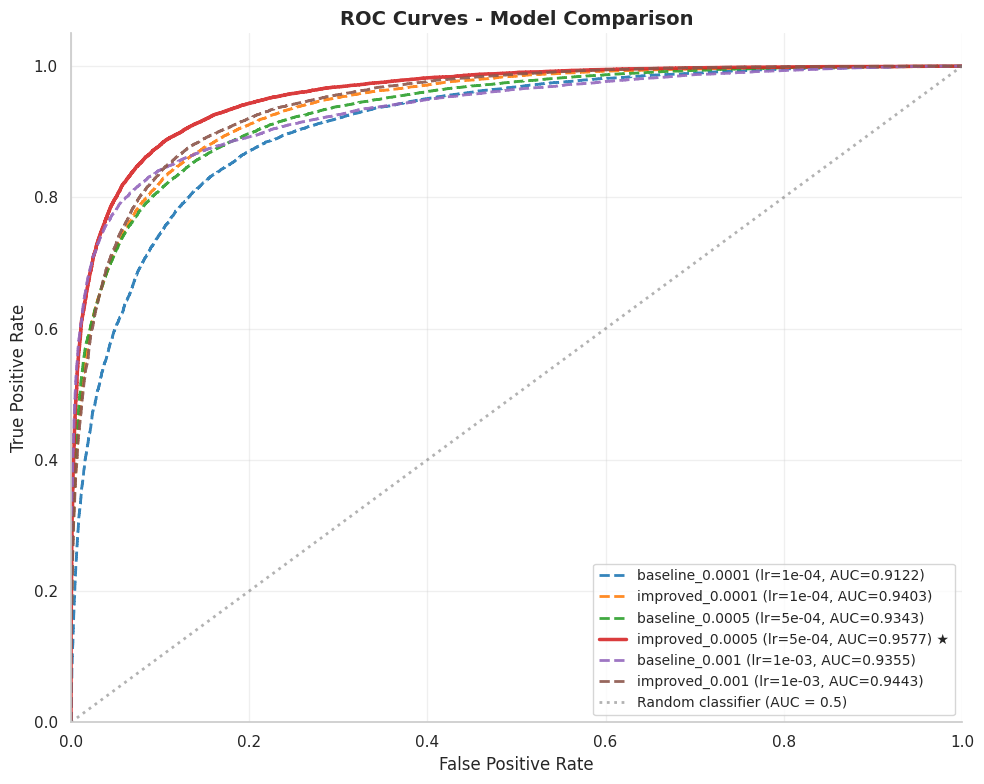


=== Best Model: improved_0.0005 ===
ROC AUC Score: 0.9577
Total validation samples: 44005
Positive samples: 17823 (40.5%)
Negative samples: 26182 (59.5%)

Optimal threshold (Youden's J): 0.4465
  → TPR (Sensitivity): 0.8873
  → FPR: 0.1063
  → Specificity: 0.8937


In [15]:
from sklearn.metrics import roc_curve, auc


def plot_roc_curves_all_models(
    experiments: List[Dict[str, float | str | keras.callbacks.History]],
    val_dataset: tf.data.Dataset,
) -> None:
    """
    Plot ROC curves for all models on the same chart for comparison.
    
    Args:
        experiments: List of experiment results
        val_dataset: Validation dataset to generate predictions on
    """
    if not experiments:
        print("No experiments available for ROC curve plotting.")
        return
    
    print("Generating ROC curves for all models...")
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Color palette for different models
    colors = plt.cm.tab10.colors
    
    # Store statistics for best model
    best_exp = max(experiments, key=lambda x: x["val_roc_auc"])
    best_stats = None
    
    # Plot ROC curve for each model
    for exp_idx, exp in enumerate(experiments):
        model = exp["model"]
        model_name = exp["model_name"]
        lr = exp["learning_rate"]
        
        # Collect true labels and predictions
        y_true = []
        y_pred = []
        
        for images, labels in val_dataset:
            predictions = model.predict(images, verbose=0)
            y_true.extend(labels.numpy())
            y_pred.extend(predictions.flatten())
        
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        
        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        
        # Store stats for best model
        if exp == best_exp:
            best_stats = {
                "y_true": y_true,
                "fpr": fpr,
                "tpr": tpr,
                "thresholds": thresholds,
                "roc_auc": roc_auc,
                "model_name": model_name,
            }
        
        # Plot ROC curve
        color = colors[exp_idx % len(colors)]
        linestyle = "-" if exp == best_exp else "--"
        linewidth = 2.5 if exp == best_exp else 2
        
        label = f"{model_name} (lr={lr:.0e}, AUC={roc_auc:.4f})"
        if exp == best_exp:
            label += " ★"
        
        ax.plot(
            fpr,
            tpr,
            color=color,
            lw=linewidth,
            linestyle=linestyle,
            label=label,
            alpha=0.9,
        )
    
    # Plot diagonal reference line (random classifier)
    ax.plot(
        [0, 1],
        [0, 1],
        color="gray",
        lw=2,
        linestyle=":",
        label="Random classifier (AUC = 0.5)",
        alpha=0.6,
    )
    
    # Configure plot
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate", fontsize=12)
    ax.set_ylabel("True Positive Rate", fontsize=12)
    ax.set_title("ROC Curves - Model Comparison", fontsize=14, fontweight="bold")
    ax.legend(loc="lower right", fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics for best model
    if best_stats:
        print(f"\n=== Best Model: {best_stats['model_name']} ===")
        print(f"ROC AUC Score: {best_stats['roc_auc']:.4f}")
        print(f"Total validation samples: {len(best_stats['y_true'])}")
        print(f"Positive samples: {best_stats['y_true'].sum():.0f} ({100 * best_stats['y_true'].mean():.1f}%)")
        print(f"Negative samples: {(1 - best_stats['y_true']).sum():.0f} ({100 * (1 - best_stats['y_true'].mean()):.1f}%)")
        
        # Find optimal threshold (Youden's J statistic: maximizes TPR - FPR)
        j_scores = best_stats['tpr'] - best_stats['fpr']
        optimal_idx = np.argmax(j_scores)
        optimal_threshold = best_stats['thresholds'][optimal_idx]
        optimal_tpr = best_stats['tpr'][optimal_idx]
        optimal_fpr = best_stats['fpr'][optimal_idx]
        
        print(f"\nOptimal threshold (Youden's J): {optimal_threshold:.4f}")
        print(f"  → TPR (Sensitivity): {optimal_tpr:.4f}")
        print(f"  → FPR: {optimal_fpr:.4f}")
        print(f"  → Specificity: {1 - optimal_fpr:.4f}")


# Generate ROC curves for all models
plot_roc_curves_all_models(experiment_results, val_ds)

In [16]:
def create_submission(model, model_name: str = "improved"):
    """Generate test set predictions and save submission CSV (batched to avoid OOM)."""
    from skimage.io import imread
    
    test_files = sorted([str(f) for f in TEST_DIR.glob("*.tif")])
    
    print(f"Predicting {len(test_files):,} test images...")
    submission = pd.DataFrame()
    
    for idx in range(0, len(test_files), 5000):
        batch = test_files[idx:idx + 5000]
        test_df = pd.DataFrame({"path": batch})
        test_df["id"] = test_df.path.map(lambda x: Path(x).stem)
        test_df["image"] = test_df["path"].map(imread)
        
        X_test = np.stack(test_df["image"].values).astype(np.float32) / 255.0
        test_df["label"] = model.predict(X_test, verbose=1)
        
        submission = pd.concat([submission, test_df[["id", "label"]]], ignore_index=True)
        print(f"  {idx + len(batch):,}/{len(test_files):,} complete")
    
    submission.to_csv("submission.csv", index = False, header = True)
    display(submission.head())
    
    return submission


In [17]:
# Create submission using the best trained model
if experiment_results:
    # Find the model with highest val_roc_auc
    best_result = max(experiment_results, key=lambda x: x["val_roc_auc"])
    best_model = best_result["model"]
    best_model_name = best_result["model_name"]
    
    print(f"\n{'='*60}")
    print(f"Best model: {best_model_name}")
    print(f"Validation ROC AUC: {best_result['val_roc_auc']:.4f}")
    print(f"Validation Accuracy: {best_result['val_accuracy']:.4f}")
    print(f"{'='*60}\n")
    
    # Create submission
    submission = create_submission(best_model, model_name=best_model_name)
else:
    print("No experiments run. Train models first to create submission.")


Best model: improved_0.0005
Validation ROC AUC: 0.9574
Validation Accuracy: 0.8927

Predicting 57,458 test images...
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
  5,000/57,458 complete
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
  10,000/57,458 complete
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
  15,000/57,458 complete
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
  20,000/57,458 complete
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
  25,000/57,458 complete
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
  30,000/57,458 complete
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
  35,000/57,458 complete
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
  40,000/57,458 complete
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
  45,000/57,458 complete
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
  50,000/57,458 complete
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
  55,000/57,458 complete
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step
  57,458/57,458 complete


,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.998353
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.340435
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.775384
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.011150
4,000270442cc15af719583a8172c87cd2bd9c7746,0.002018


In [18]:
experiment_results

[{'model_name': 'baseline_0.0001',
  'learning_rate': 0.0001,
  'dropout_conv': 0.3,
  'dropout_dense': 0.5,
  'epochs_trained': 2,
  'val_loss': 0.6639852523803711,
  'val_accuracy': 0.7428019642829895,
  'val_roc_auc': 0.9114616513252258,
  'history': <keras.src.callbacks.history.History at 0x782d0c939150>,
  'model': <Sequential name=baseline_cnn, built=True>},
 {'model_name': 'improved_0.0001',
  'learning_rate': 0.0001,
  'dropout_conv': 0.35,
  'dropout_dense': 0.45,
  'epochs_trained': 4,
  'val_loss': 0.33710435032844543,
  'val_accuracy': 0.8684240579605103,
  'val_roc_auc': 0.9397314786911011,
  'history': <keras.src.callbacks.history.History at 0x782d0ed9fb10>,
  'model': <Functional name=improved_cnn, built=True>},
 {'model_name': 'baseline_0.0005',
  'learning_rate': 0.0005,
  'dropout_conv': 0.3,
  'dropout_dense': 0.5,
  'epochs_trained': 3,
  'val_loss': 0.39678144454956055,
  'val_accuracy': 0.833587110042572,
  'val_roc_auc': 0.9341230988502502,
  'history': <keras.sr

In [19]:
experiment_results

[{'model_name': 'baseline_0.0001',
  'learning_rate': 0.0001,
  'dropout_conv': 0.3,
  'dropout_dense': 0.5,
  'epochs_trained': 2,
  'val_loss': 0.6639852523803711,
  'val_accuracy': 0.7428019642829895,
  'val_roc_auc': 0.9114616513252258,
  'history': <keras.src.callbacks.history.History at 0x782d0c939150>,
  'model': <Sequential name=baseline_cnn, built=True>},
 {'model_name': 'improved_0.0001',
  'learning_rate': 0.0001,
  'dropout_conv': 0.35,
  'dropout_dense': 0.45,
  'epochs_trained': 4,
  'val_loss': 0.33710435032844543,
  'val_accuracy': 0.8684240579605103,
  'val_roc_auc': 0.9397314786911011,
  'history': <keras.src.callbacks.history.History at 0x782d0ed9fb10>,
  'model': <Functional name=improved_cnn, built=True>},
 {'model_name': 'baseline_0.0005',
  'learning_rate': 0.0005,
  'dropout_conv': 0.3,
  'dropout_dense': 0.5,
  'epochs_trained': 3,
  'val_loss': 0.39678144454956055,
  'val_accuracy': 0.833587110042572,
  'val_roc_auc': 0.9341230988502502,
  'history': <keras.sr